# Digit Classification of MNIST Dataset

Digit Classification is a classical problem in the world of image classification and Machine Learning. To fetch decent results, it doesn't need any sophisticated architectures which is why I'm attacking this problem using Linear Classification.



In [31]:
import torch
import matplotlib.pyplot as plt
import numpy
from torchvision.datasets import MNIST

MNIST dataset is already available in the torchvision library and can be easily imported/downloaded from there

In [32]:
from torchvision import transforms
from torch.utils.data import Subset

The image is a 28*28 grayscale image

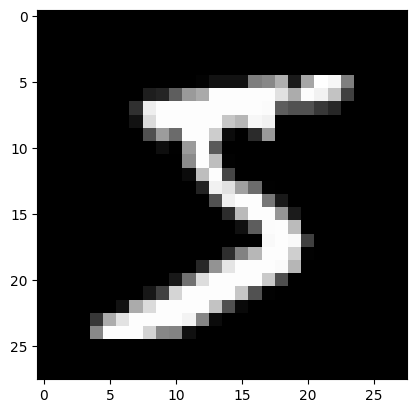

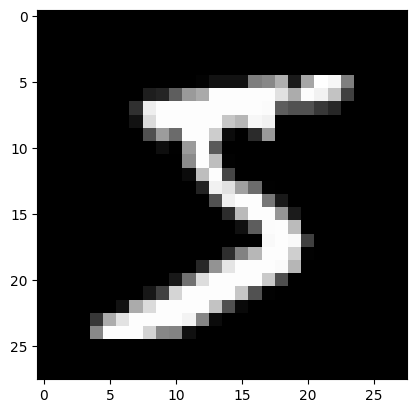

In [33]:
mnist_dataset = MNIST(root=".",
                      train=True,
                      download=True)

# can't index on a dataset so will have to convert it to a list first
plt.imshow(list(mnist_dataset)[0][0], cmap='gray')

Since the problem doesn't require all the images in the dataset, the model can be trained on only 20,000 images.

The number of images can be increase which will certainly increase the accuracy of the model.

In [34]:
mnist_dataset = MNIST(root=".",
                      train=True,
                      download=True,
                      transform=transforms.ToTensor(),
                      )

num_samples = 10000
mnist_dataset = Subset(mnist_dataset, range(num_samples))
mnist_dataset = list(mnist_dataset)
print(len(list(mnist_dataset)))

10000
10000


In [35]:
mnist_train = mnist_dataset[:7000]
mnist_val = mnist_dataset[7000:9000]
mnist_test = mnist_dataset[9000:]

Cross-Entropy Loss in vectorized form is

\begin{equation}
H(y, t) = -\frac{1}{N} \sum_{i=1}^{N} t_i \cdot \log(y_i)
\end{equation}

For our purpose, we don't need to input the softmax of our logit. Instead, inputting the logit will be sufficient as we only need to get the highest probability and compare it against individual target values.

In [36]:
from torch import nn

criterion = nn.CrossEntropyLoss()

In [37]:
from torch.utils.data import DataLoader

def accuracy(model, data):
  ''' Calculate the accuracy of the model over a dataset data
  '''
  correct, total = 0, 0
  dataset = DataLoader(data, batch_size=100)

  for X, t, in dataset:
    x = X.reshape(-1, 28*28)
    z = model(x)
    pred = torch.argmax(torch.softmax(z, dim=1), axis=1)

    correct += int(sum(pred == t))
    total += t.shape[0]

  return correct / total if total != 0 else 0

Accuracy for the Linear model at this stage is poor because it hasn't been trained.

In [38]:
model = nn.Linear(in_features=28*28, out_features=10) # still need to train the model

print(accuracy(model, mnist_train))

0.039857142857142855
0.09257142857142857


In [39]:
from torch.optim import SGD
from tqdm import tqdm

def train_model(model,
                train_data,
                val_data,
                learning_rate=0.005,
                batch_size=100,
                num_epochs=10,
                plot_every=10):

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  optimizer = SGD(model.parameters(), lr=learning_rate)

  iters, train_loss, train_acc, val_acc = [], [], [], []
  iter_count = 0

  try:
    for epoch in tqdm(range(num_epochs)):
      for i, (X, t) in enumerate(train_loader):

        z = model(X.reshape(-1, 28*28))

        loss = criterion(z, t)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        iter_count += 1
        if iter_count % plot_every == 0:
          iters.append(iter_count)
          train_loss.append(float(loss))
          train_acc.append(accuracy(model, train_data))
          val_acc.append(accuracy(model, val_data))
  finally:
    plt.figure()
    plt.plot(iters[:len(train_loss)], train_loss)
    plt.ylabel("Training Loss")
    plt.xlabel("Iterations")
    plt.title("Loss Over Iterations For Training")

    plt.figure()
    plt.plot(iters[:len(train_acc)], train_acc)
    plt.plot(iters[:len(val_acc)], val_acc)
    plt.ylabel("Accuracy")
    plt.xlabel("Iterations")
    plt.title("Accuracy Over Iterations For Training")
    plt.legend(["Training", "Validation"])


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


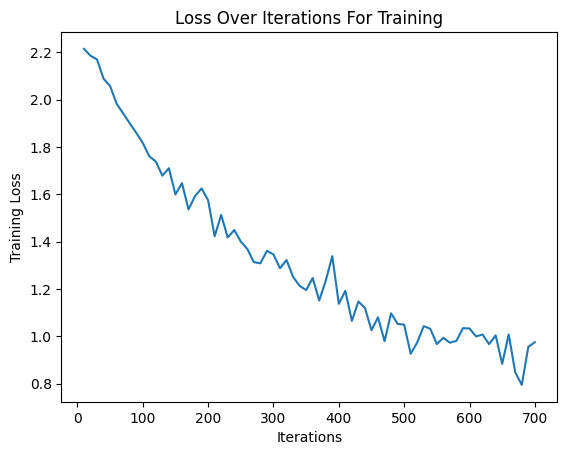

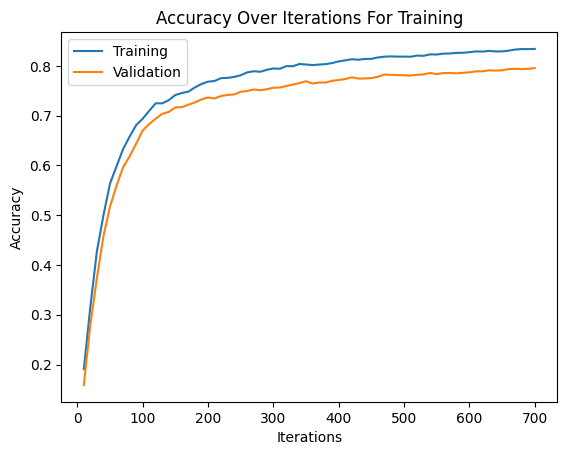

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


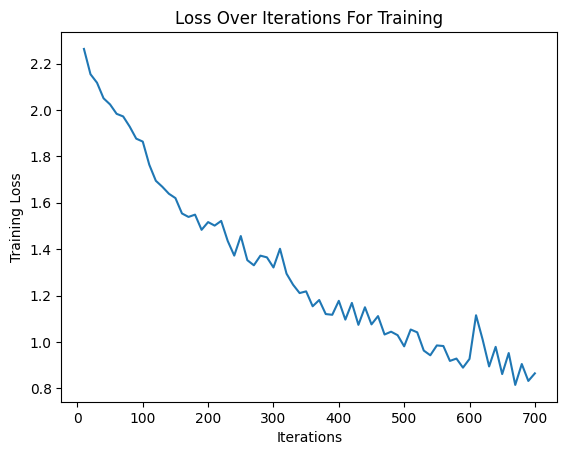

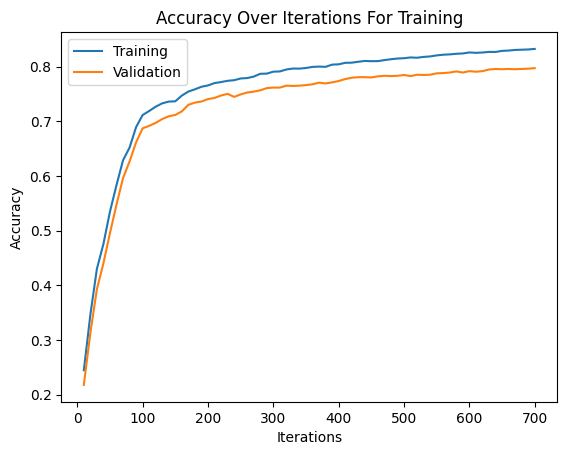

In [40]:
model = nn.Linear(in_features=28*28, out_features=10)
train_model(model, mnist_train, mnist_val)

Accuracy for the model has increased a lot after training it.

In [41]:
print(accuracy(model, mnist_test))

0.841
0.843


### Hyperparameter Tuning

Hyperparameter Tuing can't be easily done with Stochastic Gradient Descent (or any other optimization technique) which is why it's done at the end by comparing different model training scores.

In [42]:
scores = []

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


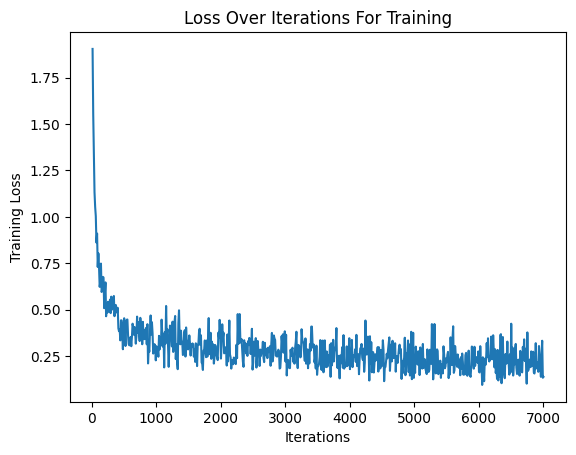

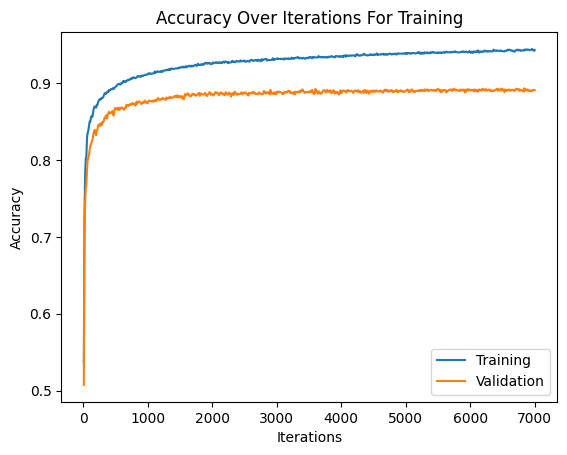

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


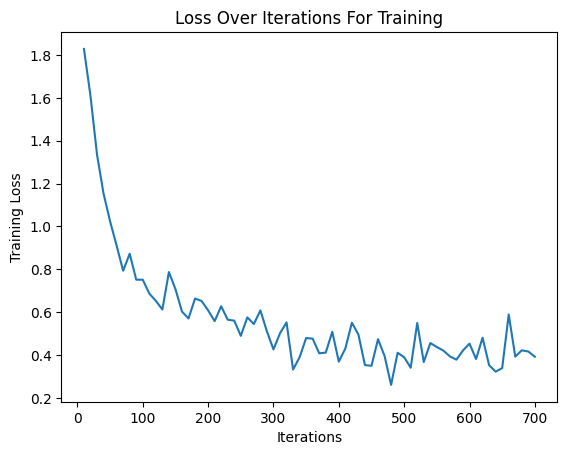

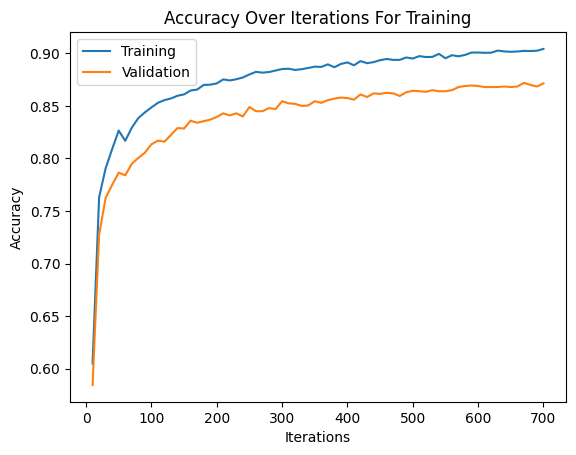

In [43]:
model = nn.Linear(in_features=28*28, out_features=10)
train_model(model, mnist_train, mnist_val, learning_rate=0.05, num_epochs=10)
scores.append(accuracy(model, mnist_test))

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


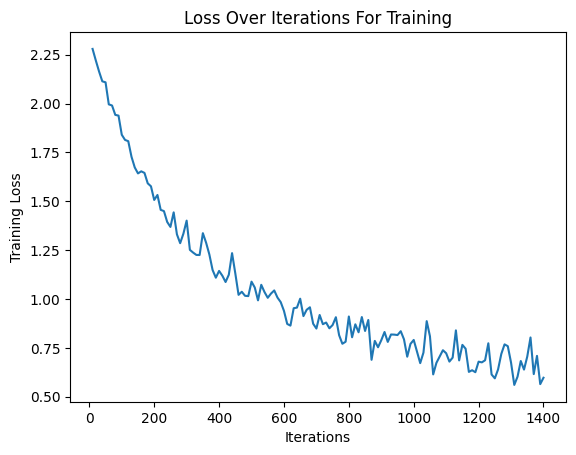

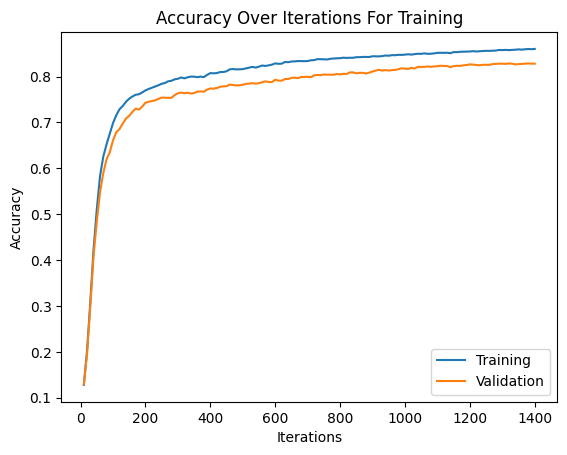

In [44]:
model = nn.Linear(in_features=28*28, out_features=10)
train_model(model, mnist_train, mnist_val, learning_rate=0.005, num_epochs=20)
scores.append(accuracy(model, mnist_test))

100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


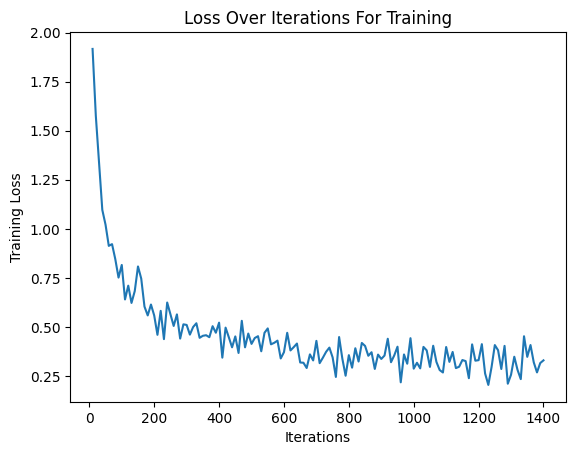

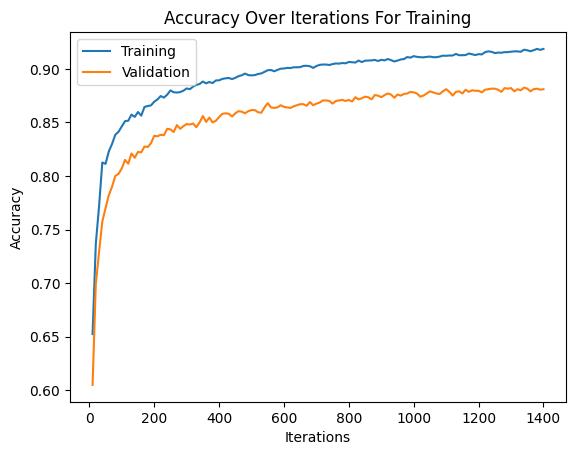

In [45]:
model = nn.Linear(in_features=28*28, out_features=10)
train_model(model, mnist_train, mnist_val, learning_rate=0.05, num_epochs=20)
scores.append(accuracy(model, mnist_test))

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


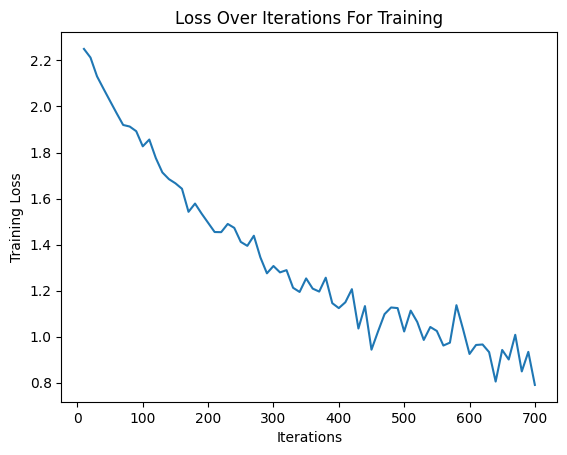

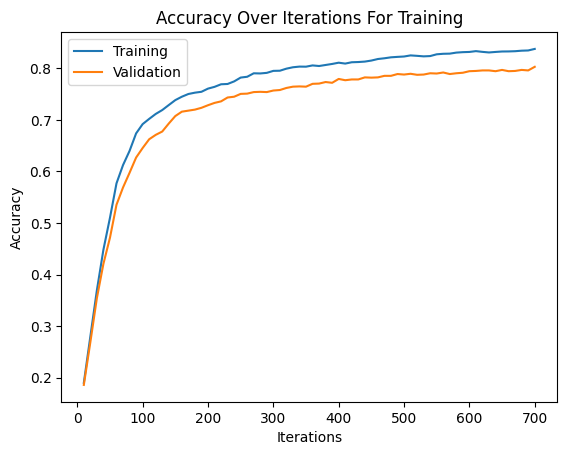

In [46]:
model = nn.Linear(in_features=28*28, out_features=10)
train_model(model, mnist_train, mnist_val, learning_rate=0.005, num_epochs=10)
scores.append(accuracy(model, mnist_test))

In [47]:
print(scores)

[0.902, 0.868, 0.912, 0.844]


The best hyperparameter configuration is when number of epochs is 20 and learning rate is 0.05.